# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import sys

# sys.path.append('../../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [2]:
country = "us"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


## VC-Bipartite Network Construction

Early-stage:
- Pre-seed
- Seed
- Series A

Late-stage:
- Series B em diante (B, C, D...)

In [ ]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

vc_investments['investor_uuid'] = vc_investments[['investor_uuid', 'investment_type']].agg('-'.join, axis=1)
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
vc_early_investments = vc_investments[vc_investments['investment_type'].isin(early_stages)]

late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown'])
vc_late_investments = vc_investments[vc_investments['investment_type'].isin(late_stages)]

print("\nSample of VC investments:")
display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
print(vc_investments[display_cols].head())

print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_early_investments, vc_late_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['total_funding_usd'] = (vc_vc_investments_pairs['total_funding_usd_left_vc'])
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'total_funding_usd_left_vc','total_funding_usd_right_vc']].head())

Found 104618 VC investments
Unique companies with VC funding: 16932

Sample of VC investments:
  company_name                        investor_name            investor_types  \
0       Scribd                    Redpoint-series_a           venture capital   
1      MeetMoi       Acadia Woods Partners-series_a           venture capital   
2        OpenX         First Round Capital-series_a           venture capital   
3        OpenX  Oreilly AlphaTech Ventures-series_a  micro vc,venture capital   
4        OpenX   Mangrove Capital Partners-series_a           venture capital   

   total_funding_usd  
0        106750000.0  
1          5575000.0  
2         70511200.0  
3         70511200.0  
4         70511200.0  
\VC-VC pairs:
Created 200727 investment pairs
Covering 5237 unique investors
                               org_uuid investor_name_left_vc  \
0  21e77067-5537-408e-cad7-e5e72bb6ad86     Redpoint-series_a   
1  21e77067-5537-408e-cad7-e5e72bb6ad86     Redpoint-series_a   
2  21e77

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [ ]:
# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    vc_vc_investments_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
    'investor_name_left_vc',
    'investor_name_right_vc',
    'total_funding_usd',
    'VCs left',
    'VCs right',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

KeyboardInterrupt: 

#### Comments

...

## Time Series Ecological Network Analysis

In [5]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
vc_vc_inv_pairs_ts = vc_vc_investments_pairs.copy()

# Convert to datetime and extract year
# vc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_ts['announced_year'])
vc_vc_inv_pairs_ts['year'] = vc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2005
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts.dropna(subset=['year'])
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= min_year) & (vc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2005 to 2023
Total investments with dates: 188,702

Investments per year:
year
2005      445
2006      388
2007      457
2008      601
2009      510
2010      801
2011     1053
2012     1217
2013     1878
2014     3315
2015     6106
2016     8592
2017    10697
2018    16055
2019    21176
2020    25197
2021    49650
2022    28463
2023    12101
Name: count, dtype: int64


### Snapshot-based analysis

In [ ]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        """ year_edges = extract_bipartite_edges_from_pairs(
            cur_year_vc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        ) """

        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            cur_year_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_vcs_left': basic_metrics['set_0_size'],
            'num_vcs_right': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...
Year 2005: 251 nodes, 442 edges, Connectance: 0.029, Nestedness: 1.7, Modularity: 0.454
Year 2006: 280 nodes, 383 edges, Connectance: 0.021, Nestedness: 1.0, Modularity: 0.468
Year 2007: 350 nodes, 445 edges, Connectance: 0.015, Nestedness: 0.8, Modularity: 0.484
Year 2008: 421 nodes, 591 edges, Connectance: 0.014, Nestedness: 0.9, Modularity: 0.469
Year 2009: 366 nodes, 497 edges, Connectance: 0.015, Nestedness: 0.8, Modularity: 0.482
Year 2010: 517 nodes, 789 edges, Connectance: 0.013, Nestedness: 1.0, Modularity: 0.481
Year 2011: 599 nodes, 1025 edges, Connectance: 0.012, Nestedness: 1.4, Modularity: 0.441
Year 2012: 767 nodes, 1189 edges, Connectance: 0.008, Nestedness: 0.9, Modularity: 0.462
Year 2013: 970 nodes, 1840 edges, Connectance: 0.008, Nestedness: 1.2, Modularity: 0.436
Year 2014: 1493 nodes, 3222 edges, Connectance: 0.006, Nestedness: 1.1, Modularity: 0.399
Year 2015: 2071 nodes, 5940 edges, Connectance: 0.006, Nestedness: 1.

In [ ]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_vcs_left  num_vcs_right  num_edges  density  \
count    19.000     19.000           0.0            0.0     19.000   19.000   
mean   2014.000   2496.789           NaN            NaN   9688.947    0.009   
std       5.627   2467.051           NaN            NaN  12847.518    0.007   
min    2005.000    251.000           NaN            NaN    383.000    0.003   
25%    2009.500    469.000           NaN            NaN    690.000    0.003   
50%    2014.000   1493.000           NaN            NaN   3222.000    0.006   
75%    2018.500   4164.500           NaN            NaN  13817.000    0.014   
max    2023.000   8443.000           NaN            NaN  48269.000    0.029   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       19.000           19.000      19.000                  0.0   
mean         0.009            1.063       0.400                  NaN   
std          0.007            0.254       0

Evolution of ecological metrics over time in the accelerator-VC ecosystem.

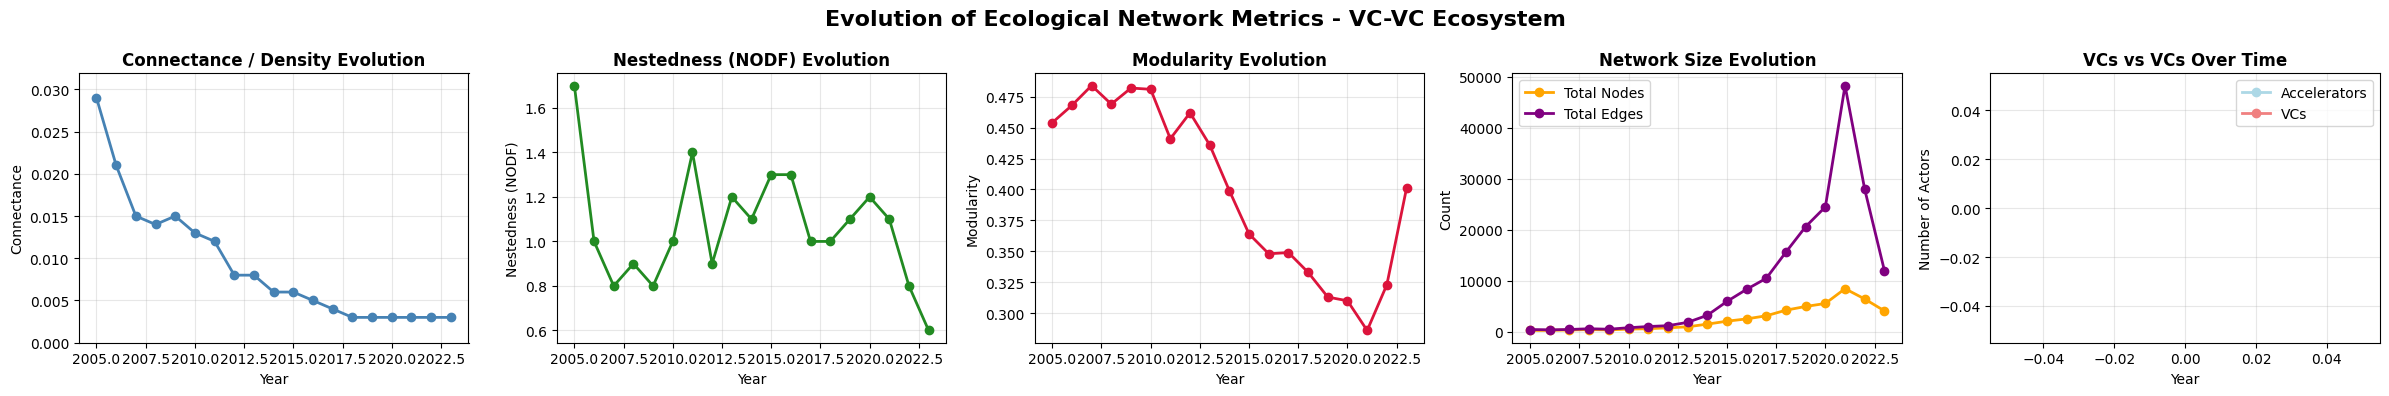

In [9]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_df['year'], ts_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[4].plot(ts_df['year'], ts_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0015 per year (total: -0.0264)
nestedness_nodf: -0.0614 per year (total: -1.1052)
modularity: -0.0030 per year (total: -0.0533)
num_nodes: +213.6111 per year (total: +3845.0000)
num_edges: +642.1111 per year (total: +11558.0000)

Correlations between metrics and time:
connectance: r=-0.900 (decreasing trend)
nestedness_nodf: r=-0.291 (decreasing trend)
modularity: r=-0.860 (decreasing trend)


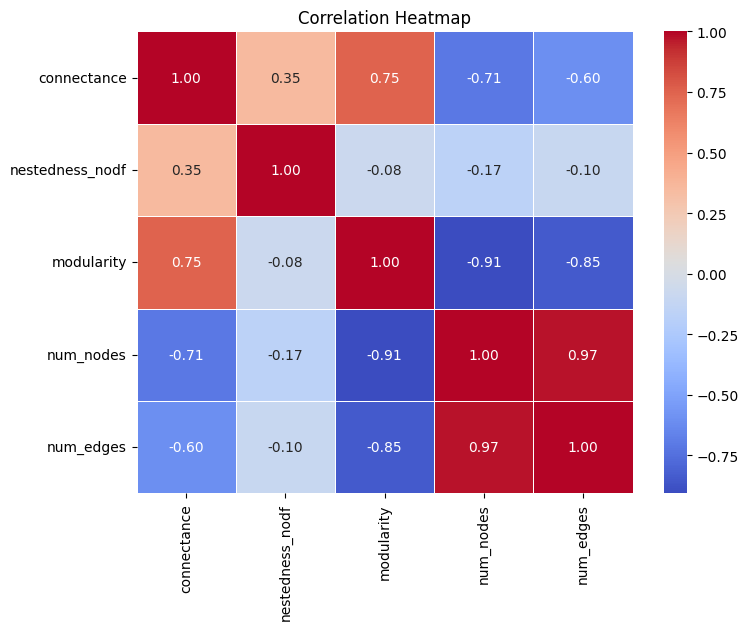

In [9]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

### Cumulative network analysis (5 years window)

In [12]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year + cumulative_window, max_year + 1):
    cur_window_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] <= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        # Extract bipartite edges for this year
        """ window_edges = extract_bipartite_edges_from_pairs(
            cur_window_vc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        ) """
        
        # Analyze bipartite structure for this year
        window_analysis = analyze_bipartite_structure_robust(
            cur_window_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        cumulative_basic_metrics = window_analysis['basic_metrics']
        cumulative_eco_summary = window_analysis['ecological_summary']
        
        # Store metrics for this year
        cumulative_year_metrics = {
            'year': year,
            'num_nodes': cumulative_basic_metrics['num_nodes'],
            'num_vcs_left': cumulative_basic_metrics['set_0_size'],
            'num_vcs_right': cumulative_basic_metrics['set_1_size'],
            'num_edges': cumulative_basic_metrics['num_edges'],
            'density': cumulative_basic_metrics['density'],
            'connectance': cumulative_eco_summary['connectance'],
            'nestedness_nodf': cumulative_eco_summary['nestedness_nodf'],
            'modularity': cumulative_eco_summary['modularity'],
            # 'cross_assortativity': cumulative_eco_summary['cross_assortativity'],
            'num_components': cumulative_basic_metrics['num_components']
        }
        
        ts_cumulative_metrics.append(cumulative_year_metrics)
        
        print(f"Year {year}: {cumulative_basic_metrics['num_nodes']} nodes, {cumulative_basic_metrics['num_edges']} edges, "
              f"Connectance: {cumulative_eco_summary['connectance']:.3f}, "
              f"Nestedness: {cumulative_eco_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {cumulative_eco_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...
Year 2010: 1500 nodes, 3002 edges, Connectance: 0.006, Nestedness: 1.1, Modularity: 0.416
Year 2011: 1738 nodes, 3558 edges, Connectance: 0.005, Nestedness: 1.1, Modularity: 0.409
Year 2012: 1994 nodes, 4301 edges, Connectance: 0.005, Nestedness: 1.1, Modularity: 0.397
Year 2013: 2349 nodes, 5650 edges, Connectance: 0.005, Nestedness: 1.1, Modularity: 0.388
Year 2014: 3011 nodes, 8178 edges, Connectance: 0.004, Nestedness: 1.2, Modularity: 0.362
Year 2015: 3945 nodes, 13415 edges, Connectance: 0.004, Nestedness: 1.3, Modularity: 0.333
Year 2016: 5013 nodes, 20597 edges, Connectance: 0.003, Nestedness: 1.4, Modularity: 0.309
Year 2017: 6271 nodes, 29670 edges, Connectance: 0.003, Nestedness: 1.3, Modularity: 0.295
Year 2018: 7973 nodes, 43417 edges, Connectance: 0.003, Nestedness: 1.3, Modularity: 0.276
Year 2019: 9706 nodes, 61187 edges, Connectance: 0.003, Nestedness: 1.4, Modularity: 0.263
Year 2020: 11455 nodes, 81455 ed

In [ ]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_vcs_left  num_vcs_right   num_edges  density  \
count    14.000     14.000           0.0            0.0      14.000   14.000   
mean   2016.500   7281.643           NaN            NaN   48611.071    0.004   
std       4.183   5469.610           NaN            NaN   52657.156    0.001   
min    2010.000   1500.000           NaN            NaN    3002.000    0.002   
25%    2013.250   2514.500           NaN            NaN    6282.000    0.003   
50%    2016.500   5642.000           NaN            NaN   25133.500    0.004   
75%    2019.750  11017.750           NaN            NaN   76388.000    0.005   
max    2023.000  16590.000           NaN            NaN  142943.000    0.006   

       connectance  nestedness_nodf  modularity  num_components  
count       14.000           14.000      14.000             0.0  
mean         0.004            1.338       0.317             NaN  
std          0.001            0.156       0.066     

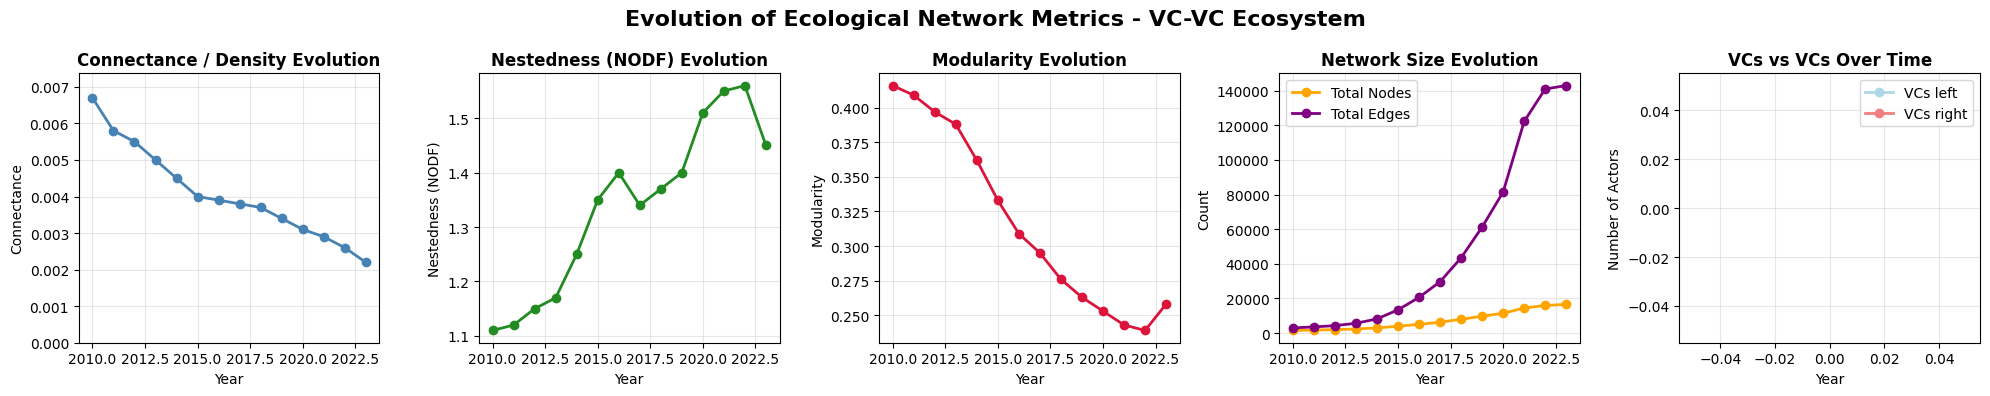

In [7]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_cumulative_df['year'], ts_cumulative_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='VCs left')
    axes[4].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs right')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0030 per year (total: -0.0396)
nestedness_nodf: -0.3461 per year (total: -4.4989)
modularity: -0.0071 per year (total: -0.0921)
num_nodes: +80.0769 per year (total: +1041.0000)
num_edges: +254.3846 per year (total: +3307.0000)

Correlations between metrics and time:
connectance: r=-0.967 (decreasing trend)
nestedness_nodf: r=-0.746 (decreasing trend)
modularity: r=-0.905 (decreasing trend)


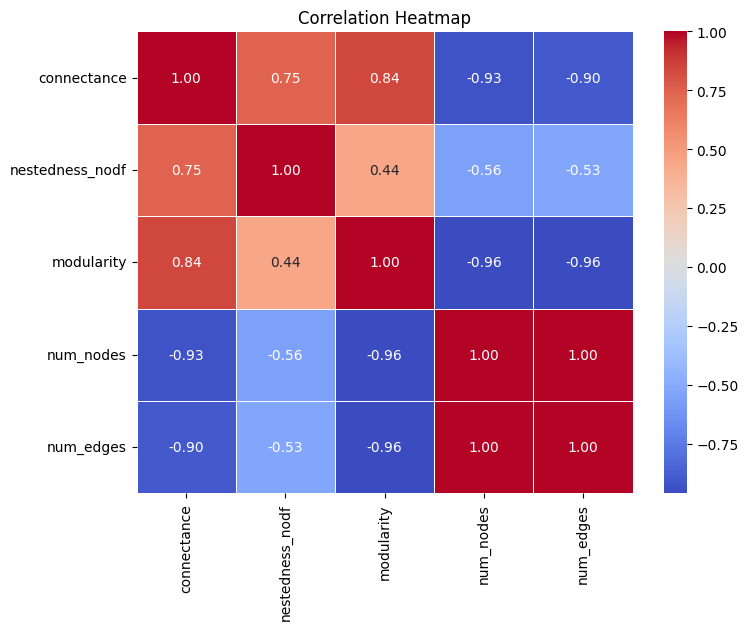

In [ ]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_cumulative_df.columns:
            correlation = ts_cumulative_df['year'].corr(ts_cumulative_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")